In [8]:
import lightkurve as lk

kic_id = 'KIC10011070'
flare_time =415.62
quarter = 4

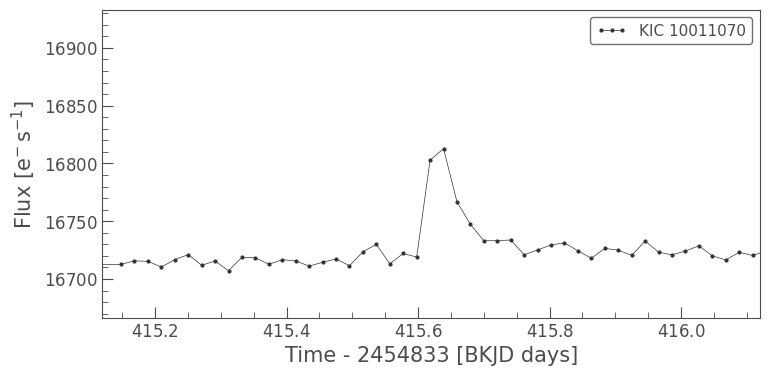

In [9]:
%matplotlib inline
lc = lk.search_lightcurve(kic_id, author="Kepler", cadence="long", quarter=quarter).download()
lc.plot(marker='o').set_xlim(flare_time-0.5, flare_time+0.5);

In [10]:
tpf = lk.search_targetpixelfile(kic_id, author="Kepler", cadence="long", quarter=4).download()

In [14]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)

from src.flare_localization import FlareLocalization
flare = FlareLocalization(flare_time=flare_time, tpf=tpf)
flare.compute_flare_image()

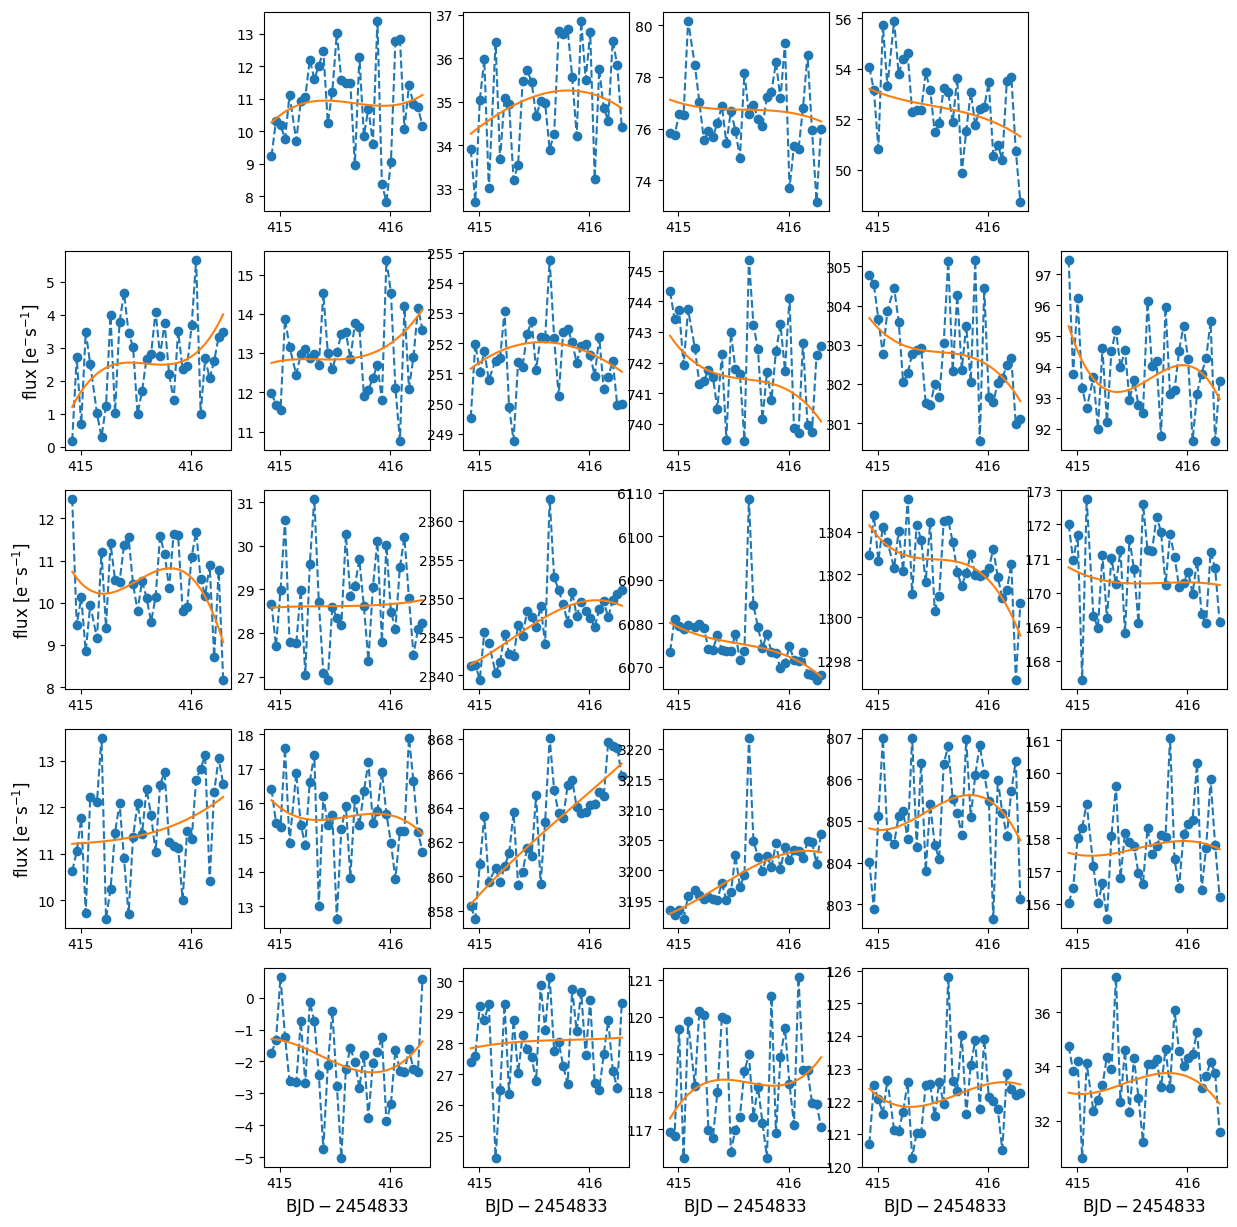

In [15]:
import numpy as np
import matplotlib.pyplot as plt

def plotDetrendingPixelFLuxes(time: np.ndarray, flux: np.ndarray, mean_flux: np.ndarray) -> None:
    n_xpix = flux.shape[1]
    n_ypix = flux.shape[2]
    plt.figure(figsize=(15,15))
    c=1
    for i in range(n_xpix):
            i= n_xpix - 1 - i
            for j in range(n_ypix):
                if not(np.isnan(flux[0, i, j])):
                    plt.subplot(n_xpix, n_ypix, c)
                    plt.plot(time, flux[:, i, j], "o--")
                    plt.plot(time, mean_flux[:, i, j], "-")
                    if j == 0:
                        plt.ylabel(r"$\mathrm{flux}$ $[\mathrm{e}^{-} \mathrm{s}^{-1}]$", fontsize=12)
                    if i ==0:
                        plt.xlabel( r"$\mathrm{BJD  -  2454833}$" , fontsize=12)
                c = c + 1
    plt.show()

plotDetrendingPixelFLuxes(time=flare.flare_image.time_within_window_with_flare,
                          flux=flare.flare_image.tpfs_within_window_with_flare,
                          mean_flux=flare.flare_image.quiet_stellar_fluxes_within_window_with_flare)



In [16]:
flare.localize_flare()

center_of_brightness = (1.7703151297342723, 3.0256892765711996)
p0: [201.0256892765712, 88.77031512973427, 118.27069305628538, 4.380396039121681]


/home/astrovalera/science/LOSE/src/mcmc.py:157: RuntimeWarning: invalid value encountered in log
  return -np.nansum(model_image - data * np.log(model_image))


p0: [201.53371333781254, 89.28994324978416, 75.58011596771816, 1.672600777593545]
flare col : 201.03529387358265 - 0.07980266250905288 + 0.08030614675172387
flare row : 88.78931328487434 - 0.07978550974287657 + 0.08089518228301529
flare flux : 75.09420780363837 - 9.860487563302812 + 10.606315000269007
offset flux $[e^{-1}s^{-1}]$ : 1.6696874503540817 - 0.29789461024676256 + 0.3232413662584044


In [17]:
flare.get_gaia_data()
print(flare.gaia_data)

       _r               Source     RA_ICRS    DE_ICRS     Gmag   pmRA  e_pmRA  \
0   0.136  2129091399748178816  291.544364  46.980123  14.9028 -4.227   0.049   
1   6.906  2129091399743340288  291.544153  46.982046  20.5577 -0.435   1.674   
2   5.292  2129091399743336192  291.543038  46.981266  20.4331 -0.751   1.316   
3  12.971  2129091395448651392  291.549029  46.978382  20.2612  2.653   1.119   

    pmDE  e_pmDE  pmRApmDEcor     Plx   e_Plx  PlxpmRAcor  PlxpmDEcor  
0 -6.384   0.048      -0.0784  1.3634  0.0234      0.1053     -0.0771  
1 -0.529   1.842      -0.1716 -0.7332  0.7420      0.1637      0.0547  
2  0.768   1.715      -0.2252 -0.0427  0.5950      0.2608     -0.1125  
3 -3.976   1.187      -0.0773  0.8873  0.5294      0.3031     -0.0468  


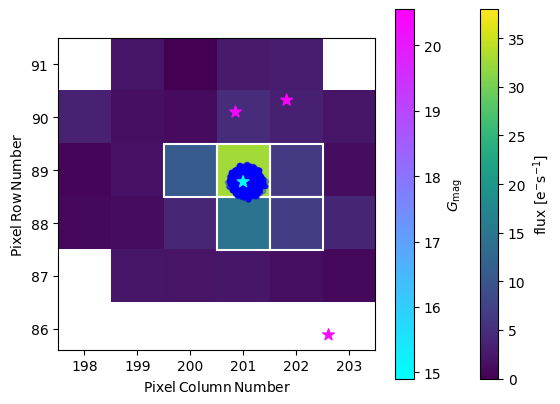

In [18]:
import matplotlib.cm as cm
from matplotlib import patches
def plot_apperture_mask(ax, tpf):
    aperture_mask = tpf.pipeline_mask
    for i in range(aperture_mask.shape[0]):
        for j in range(aperture_mask.shape[1]):
            if aperture_mask[i, j]:
                rect = patches.Rectangle(
                    xy=(j + tpf.column - 0.5, i + tpf.row - 0.5),
                            width=1,
                            height=1,
                            edgecolor="white",
                            fill=False,
                            linewidth = 1.5,
                            alpha=1.0
                        )
                ax.add_patch(rect)


def plot_residual_flare_with_mcmcm(flare, ax, extend):
    flare_image = flare.flare_image.flare_image+abs(np.min(flare.flare_image.flare_image[~np.isnan(flare.flare_image.flare_image)]))
    im = ax.imshow(flare_image, origin ="lower", extent = extend,  vmin=0,vmax=38 )
    ax.plot( flare.mcmc.chain[:,0], flare.mcmc.chain[:,1] , "b.", alpha=0.3)
    ax.set_xlabel("$\mathrm{Pixel \, Column \, Number}$")
    sccatter = ax.scatter( flare.star_positions[:, 0], flare.star_positions[:,1],  c=flare.gaia_data.Gmag, \
            s=75, marker="*", cmap=cm.cool, label = "J2015.5", zorder=100000000000)
    return im, sccatter



fig, ax = plt.subplots()
extend = [tpf.column-0.5, tpf.column + flare.flare_image.flare_image.shape[1]-0.5, tpf.row-0.5, tpf.row + flare.flare_image.flare_image.shape[0]-0.5]
plot_apperture_mask(ax, tpf)
im, sccatter = plot_residual_flare_with_mcmcm(flare, ax, extend)
ax.set_ylabel("$\mathrm{Pixel \,  Row \, Number}$")
cb = fig.colorbar(im)
cb.set_label(r"$\mathrm{ flux}$ $[\mathrm{e}^{-} \mathrm{s}^{-1}]$")
cbb = fig.colorbar(sccatter)
cbb.set_label(r"$G_\mathrm{mag}$")

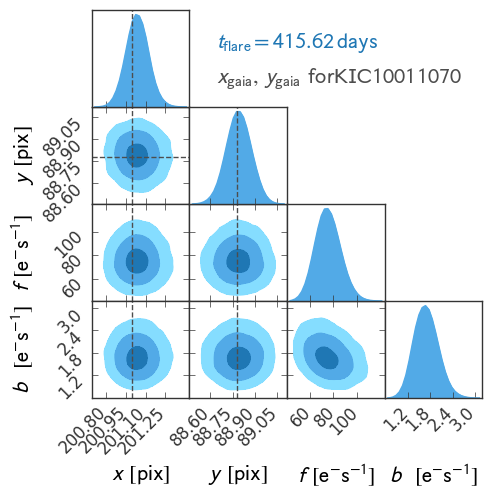

In [19]:
import pygtc

labels = [r"$x$ $[\mathrm{pix}]$", r"$y$ $[\mathrm{pix}]$",
               r"$f$ $[\mathrm{e}^{-}\mathrm{s}^{-1}]$",
               r"$b$  $[\mathrm{e}^{-}\mathrm{s}^{-1}]$"]

GTC = pygtc.plotGTC(chains=[flare.mcmc.chain],
                    paramNames=labels,
                    plotName=None, \
                    chainLabels=["$t_\mathrm{flare}=415.62\, \mathrm{days}$"], \
    	            truths=((flare.star_positions[0, 0], flare.star_positions[0, 1], None, None)),
                    nContourLevels = 3,
                    sigmaContourLevels=True,
                    truthLabels=[r"$x_\mathrm{gaia}, \,y_\mathrm{gaia}$ $\mathrm{ for "+kic_id+"}$"],   figureSize='MNRAS_page' ,
                    customLabelFont = {'family':'sans-serif', 'size':16},
                    customLegendFont = {'family':'sans-serif', 'size':16}, customTickFont =  {'family':'sans-serif', 'size':12})